# Fire Prediction Model

The Fire Prediction Project utilizes a mix of historical fire data from the [Oregon Open Data Portal](https://data.oregon.gov/Natural-Resources/ODF-Fire-Occurrence-Data-2000-2022/fbwv-q84y/about_data) and historical hourly and daily weather data from the [Open-Meteo Historical Weather API](https://open-meteo.com/en/docs/historical-weather-api) to train a model that measures fire ignition probability under varying weather features. An iterative API call is used to gather appropriate weather data, which is married with the associated fire ignition data (indicated as class 1). Concurrently, additional weather data from dates ***not*** associated with fire ignition is retrieved (indicated as class 0). 
\
\
The model used is a Random Forest Classifier, which is tuned during each run with a GridSearchCV across multiple key hyperparameters. In its final state, weather variables are declared and input into the model to determine probability of fire ignition. In this script, the variables are declared such that fire ignition would not be probable, and the probabilistic result matches based on expectation from domain knowledge.

## Imports and Installs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
import glob

%matplotlib inline

import openmeteo_requests
import requests_cache
from retry_requests import retry
import requests
from datetime import datetime
from datetime import timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Functions

The model requires weather data which is reliably associated with normal, non-fire conditions. In order to generate dates that fall outside of the Oregon fire data, a Series of dates not present in the input dataframe is generated. Later in the script, this Series will be randomly sampled against (with replacement), and the resulting dates are used for the API call. 

In [2]:
# Function for generating random dates not present in original fire dataset.
# To be used for weather data not associated with fires.


def rand_date(input_df, record_length=2000):
    minimum_date = input_df[
        "date"
    ].min()  # Initializing range of dates associated with df
    maximum_date = input_df["date"].max()

    listed_date = [minimum_date]  # Initializing list of dates with minimum
    new_dates = []

    while minimum_date != maximum_date:  # All dates not associated with fires
        minimum_date += timedelta(days=1)
        if minimum_date in input_df["date"]:
            pass
        else:
            listed_date.append(minimum_date)

    for i in range(
        record_length
    ):  # Random generation of dates not associated with fire
        rand_num = np.random.randint(0, len(listed_date))
        curr_date = listed_date[rand_num]
        new_dates.append(curr_date)

    return pd.Series(new_dates)

## Gathering Data - Historical and API

In the Oregon fire datasets, it is important to clean out various null records and account for basic data anomalies. In the below, nulls are completely removed (as this only accounts for a small proportion of the data, which has an insignifant effect on the final model training). Additionally, entries where the fire was indicated to be under control (Control_DateTime) before the fire ignited (Ign_DateTime) were removed.

In [3]:
# After reading in data, a random sample of record_length will be retrieved.
directory = os.getcwd()
files = glob.glob(f"{directory}/*.csv")
df_fire_full = pd.read_csv(files[0])
record_length = 2000

# Reading in fire data and dropping unnecessary columns for analysis
df_fire_cleaned = df_fire_full.drop(
    [
        "Serial",
        "FireCategory",
        "Area",
        "DistrictName",
        "UnitName",
        "FullFireNumber",
        "Cause_Comments",
        "LatLongDD",
        "FO_LandOwnType",
        "Twn",
        "Rng",
        "Sec",
        "Subdiv",
        "LandmarkLocation",
        "County",
        "RegUseZone",
        "RegUseRestriction",
        "Industrial_Restriction",
        "DistrictCode",
        "UnitCode",
        "DistFireNumber",
    ],
    axis=1,
)

# Pulling in most recent 2000 observations
df_fire_cleaned.sort_values(["ReportDateTime"], inplace=True, ascending=False)
df_fire_cleaned = df_fire_cleaned.sample(n=record_length)

# Dropping any null rows
df_fire_cleaned = df_fire_cleaned.dropna()

# Converting datetime columns to appropriate datatype
df_fire_cleaned["Ign_DateTime"] = pd.to_datetime(
    df_fire_cleaned["Ign_DateTime"], format="%m/%d/%Y %I:%M:%S %p"
)
df_fire_cleaned["Control_DateTime"] = pd.to_datetime(
    df_fire_cleaned["Control_DateTime"], format="%m/%d/%Y %I:%M:%S %p"
)

# Invalid data where the controlled datetime occured before the ignite datetime.
df_fire_cleaned = df_fire_cleaned.drop(
    df_fire_cleaned.index[
        df_fire_cleaned["Control_DateTime"] < df_fire_cleaned["Ign_DateTime"]
    ].tolist()
)

### API Call

The below retrieves weather data associated with the historical fire data and weather data for dates which are ***not*** present in the historical fire data. Importantly, certain variables are obtained at the hourly level, and these resulting dataframes must be rightsized for future aggregation and merging to the daily level. The end goal is combining all data at the daily level (using appropriate mean or sum aggregates) and generating a dataframe with all weather variables and an indicator (class 0 or 1) for fire ignition. 

In [4]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=5)
openmeteo = openmeteo_requests.Client(session=retry_session)

hourly_dataframe_agg = pd.DataFrame()
daily_dataframe_agg = pd.DataFrame()

for point in tqdm(range(len(df_fire_cleaned))):
    lat_current = df_fire_cleaned["Lat_DD"].iloc[point]
    long_current = df_fire_cleaned["Long_DD"].iloc[point]

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"

    # Model is built to determine fire ignition probability - using Ign_DateTime as date param
    params = {
        "latitude": lat_current,
        "longitude": long_current,
        "start_date": datetime.strftime(
            df_fire_cleaned["Ign_DateTime"].iloc[point].date(), "%Y-%m-%d"
        ),
        "end_date": datetime.strftime(
            df_fire_cleaned["Ign_DateTime"].iloc[point].date(), "%Y-%m-%d"
        ),
        "hourly": [
            "soil_moisture_0_to_7cm",
            "surface_pressure",
            "dew_point_2m",
            "apparent_temperature",
            "precipitation",
        ],
        "daily": [
            "wind_speed_10m_max",
            "et0_fao_evapotranspiration",
            "temperature_2m_max",
            "temperature_2m_min",
        ],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Los_Angeles",
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]

    # Retrieve hourly data from API. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_soil_moisture_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()
    hourly_surface_pressure = hourly.Variables(1).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
    hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()

    # Initializing dictionary with appropriate dates for hourly interval data
    # Hourly variables cut off at the end of the day of ignition
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.Time(), unit="s", utc=True).replace(
                hour=23, minute=59, second=59
            ),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm[
        : len(hourly_data["date"])
    ]
    hourly_data["surface_pressure"] = hourly_surface_pressure[
        : len(hourly_data["date"])
    ]
    hourly_data["dew_point_2m"] = hourly_dew_point_2m[: len(hourly_data["date"])]
    hourly_data["apparent_temperature"] = hourly_apparent_temperature[
        : len(hourly_data["date"])
    ]
    hourly_data["precipitation"] = hourly_precipitation[: len(hourly_data["date"])]

    # Resizing the daily fire data by duplicating entries based on number of hourly observations
    hourly_dataframe = pd.DataFrame(data=hourly_data)
    df_fire_cleaned_repeat_hour = pd.DataFrame(
        np.tile(df_fire_cleaned.iloc[point].values, (len(hourly_dataframe), 1)),
        columns=df_fire_cleaned.columns,
    )

    # Combining the hourly weather data with the duplicated fire entries
    hourly_dataframe = pd.concat(
        [hourly_dataframe, df_fire_cleaned_repeat_hour], axis=1
    )
    hourly_dataframe_agg = pd.concat(
        [hourly_dataframe_agg, hourly_dataframe], ignore_index=True, axis=0
    )

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_wind_speed_10m_max = daily.Variables(0).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(2).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(3).ValuesAsNumpy()

    # Initializing dictionary with appropriate dates for daily interval data
    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left",
        )
    }
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min

    # Ensuring weather API df and associated fire df are rightsized then combining
    daily_dataframe = pd.DataFrame(data=daily_data)
    df_fire_cleaned_repeat_day = pd.DataFrame(
        np.tile(df_fire_cleaned.iloc[point].values, (len(daily_dataframe), 1)),
        columns=df_fire_cleaned.columns,
    )
    daily_dataframe = pd.concat([daily_dataframe, df_fire_cleaned_repeat_day], axis=1)
    daily_dataframe_agg = pd.concat(
        [daily_dataframe_agg, daily_dataframe], ignore_index=True, axis=0
    )

# Getting random dates not associated with fires. Weather details will be
# used for class 0 entries in the df - no fire ignited.
generated_dates = rand_date(daily_dataframe_agg, 2000)
extra_hourly_dataframe_agg = pd.DataFrame()
extra_daily_dataframe_agg = pd.DataFrame()

for point in tqdm(range(len(generated_dates))):
    lat_long_modulo = point % len(df_fire_cleaned)
    lat_current = df_fire_cleaned["Lat_DD"].iloc[lat_long_modulo]
    long_current = df_fire_cleaned["Long_DD"].iloc[lat_long_modulo]

    # In this call, pass the randomly generated date to the start and end param
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat_current,
        "longitude": long_current,
        "start_date": datetime.strftime(generated_dates[point].date(), "%Y-%m-%d"),
        "end_date": datetime.strftime(generated_dates[point].date(), "%Y-%m-%d"),
        "hourly": [
            "soil_moisture_0_to_7cm",
            "surface_pressure",
            "dew_point_2m",
            "apparent_temperature",
            "precipitation",
        ],
        "daily": [
            "wind_speed_10m_max",
            "et0_fao_evapotranspiration",
            "temperature_2m_max",
            "temperature_2m_min",
        ],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Los_Angeles",
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]

    hourly = response.Hourly()
    hourly_soil_moisture_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()
    hourly_surface_pressure = hourly.Variables(1).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
    hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()

    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.Time(), unit="s", utc=True).replace(
                hour=23, minute=59, second=59
            ),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm[
        : len(hourly_data["date"])
    ]
    hourly_data["surface_pressure"] = hourly_surface_pressure[
        : len(hourly_data["date"])
    ]
    hourly_data["dew_point_2m"] = hourly_dew_point_2m[: len(hourly_data["date"])]
    hourly_data["apparent_temperature"] = hourly_apparent_temperature[
        : len(hourly_data["date"])
    ]
    hourly_data["precipitation"] = hourly_precipitation[: len(hourly_data["date"])]

    # No need to resize the weather API df since we are not combining with the fire data
    extra_hourly_dataframe = pd.DataFrame(data=hourly_data)
    extra_hourly_dataframe_agg = pd.concat(
        [extra_hourly_dataframe_agg, extra_hourly_dataframe], ignore_index=True, axis=0
    )

    daily = response.Daily()
    daily_wind_speed_10m_max = daily.Variables(0).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(2).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(3).ValuesAsNumpy()

    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left",
        )
    }
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min

    # No need to resize the weather API df since we are not combining with the fire data
    extra_daily_dataframe = pd.DataFrame(data=daily_data)
    extra_daily_dataframe_agg = pd.concat(
        [extra_daily_dataframe_agg, extra_daily_dataframe], ignore_index=True, axis=0
    )

# Combining the fire-related df's and the non-fire-related df's
hourly_dataframe_agg = pd.concat(
    [hourly_dataframe_agg, extra_hourly_dataframe_agg], ignore_index=True, axis=0
)
daily_dataframe_agg = pd.concat(
    [daily_dataframe_agg, extra_daily_dataframe_agg], ignore_index=True, axis=0
)

100%|██████████| 2000/2000 [06:53<00:00,  4.84it/s]


## Conversions and Cleanup

During these steps, final conversions and the ultimate goal of merging all data into a singular set are accomplished. This includes variable mappings, date conversions, aggregate groupings, and null value handling. 

In [5]:
# Replacing size class with numeric values - we consider all levels of
# fire the same since this model is aimed at measuring ignition, not severity
size_class_dict = {"A": 1, "B": 1, "C": 1, "D": 1, "E": 1, "F": 1}

daily_dataframe_agg["Size_class"] = daily_dataframe_agg["Size_class"].map(
    size_class_dict
)
hourly_dataframe_agg["Size_class"] = hourly_dataframe_agg["Size_class"].map(
    size_class_dict
)

# Converting to UTC datetime
daily_dataframe_agg["date"] = daily_dataframe_agg["date"].dt.tz_convert("UTC")
hourly_dataframe_agg["date"] = hourly_dataframe_agg["date"].dt.tz_convert("UTC")

In [6]:
# Adding a column at the date level
hourly_dataframe_agg["day"] = hourly_dataframe_agg["date"].dt.date

# Dropping columns not used in the model for analysis
hourly_dataframe_agg.drop(
    [
        "FireYear",
        "FireName",
        "EstTotalAcres",
        "Protected_Acres",
        "HumanOrLightning",
        "CauseBy",
        "GeneralCause",
        "SpecificCause",
        "Lat_DD",
        "Long_DD",
        "Ign_DateTime",
        "ReportDateTime",
        "Discover_DateTime",
        "Control_DateTime",
        "CreationDate",
        "ModifiedDate",
        "date",
    ],
    axis=1,
    inplace=True,
)

# Records with no fire assocation have a null Size_class from previous dictionary mapping.
# Converting to 0 to indicate no fire.
hourly_dataframe_agg["Size_class"] = hourly_dataframe_agg["Size_class"].fillna(
    value=0.0
)

# Aggregating the hourly data - all are averages except for precipitation, a sum.
daily_addhourly_dataframe_agg = hourly_dataframe_agg.groupby(
    ["day", "Size_class"],
    as_index=False,
).agg(
    {
        "soil_moisture_0_to_7cm": "mean",
        "surface_pressure": "mean",
        "dew_point_2m": "mean",
        "apparent_temperature": "mean",
        "precipitation": "sum",
    }
)

# Adding a column at the date level
# and dropping columns not used in the model for analysis
daily_dataframe_agg["day"] = daily_dataframe_agg["date"].dt.date
daily_dataframe_agg.drop(
    [
        "FireYear",
        "FireName",
        "EstTotalAcres",
        "Protected_Acres",
        "HumanOrLightning",
        "CauseBy",
        "GeneralCause",
        "SpecificCause",
        "Lat_DD",
        "Long_DD",
        "Ign_DateTime",
        "ReportDateTime",
        "Discover_DateTime",
        "Control_DateTime",
        "CreationDate",
        "ModifiedDate",
        "date",
    ],
    axis=1,
    inplace=True,
)

daily_dataframe_agg["Size_class"] = daily_dataframe_agg["Size_class"].fillna(value=0.0)

# Merging the aggregated hourly and the daily df's
daily_dataframe_merged = daily_dataframe_agg.merge(
    daily_addhourly_dataframe_agg, on=["day", "Size_class"], how="left"
)

## Visualizing Features

To get an initial feel for feature importance, inspect the correlation of 'Size_class', which indicates fire ignition (class 1) or no fire ignition (class 0) with the weather features. This basic visualization can also act as a domain knowledge check against which features should be negatively correlated, positively correlated, and the associated strengths. Importantly, some of these features may have more prominent effects in combination, but this offers a great gut check. 

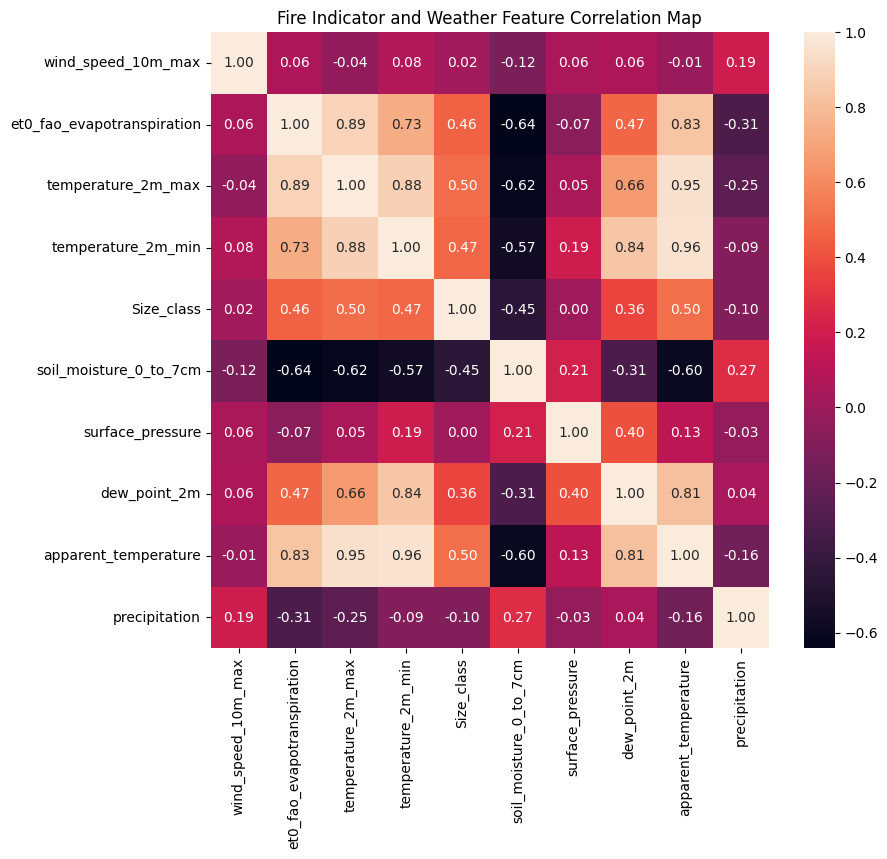

In [7]:
# Visualization to compare size class correlations with numeric variables
plt.figure(figsize=(9, 8))
plt.title("Fire Indicator and Weather Feature Correlation Map")
sns.heatmap(daily_dataframe_merged.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()

## Training & Model Evaluation

The training and test data are split and the model and grid search are initialized. Since this is a classification problem, f1 score was chosen to be the primary metric to validate against, as accuracy can be misleading when large discrepancies exist between precision and recall. 

In [8]:
# Initializing and training an ensemble model for classification. Precision &
# Recall used to identify performance instead of pure accuracy.

pd_X = daily_dataframe_merged.drop(["Size_class", "day"], axis=1)
pd_y = daily_dataframe_merged["Size_class"]
X_train, X_test, y_train, y_test = train_test_split(pd_X, pd_y, test_size=0.2)

# GridSearch to optimize hyperparameters based on the f1 score
param_grid_RFC = {
    "n_estimators": [100, 200, 300],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3, 5, 10, None],
    "max_features": [1, 3, 5, 7],
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 3],
}

# Instantiating model
RFC = RandomForestClassifier()

# GridSearch over parameters - n_jobs = -1 to improve speed, and optimizing f1 score
# instead of accuracy.
grid_RFC = GridSearchCV(
    estimator=RFC,
    param_grid=param_grid_RFC,
    verbose=0,
    cv=3,
    n_jobs=-1,
    scoring="f1_micro",
)
grid_RFC.fit(X_train, y_train)
grid_pred = grid_RFC.predict(X_test)

print("The classification report below:")
print(classification_report(y_test, grid_pred), flush=True)
print("\n")
print("The best parameters for the GridSearch:")
print(grid_RFC.best_params_, flush=True)

The classification report below:
              precision    recall  f1-score   support

         0.0       0.81      0.67      0.73       414
         1.0       0.70      0.83      0.76       381

    accuracy                           0.74       795
   macro avg       0.75      0.75      0.74       795
weighted avg       0.76      0.74      0.74       795



The best parameters for the GridSearch:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


## New Data Prediction

For context to choose test variables for prediction probabilities, reference the below distribution of features

In [9]:
daily_dataframe_merged.describe().drop(["Size_class"], axis=1)

,wind_speed_10m_max,et0_fao_evapotranspiration,temperature_2m_max,temperature_2m_min,soil_moisture_0_to_7cm,surface_pressure,dew_point_2m,apparent_temperature,precipitation
count,3975.000000,3975.000000,3975.000000,3975.000000,3975.000000,3975.000000,3975.000000,3975.000000,3975.000000
mean,8.394265,0.141829,68.425758,46.828926,0.266254,940.749207,42.220009,53.240620,0.068448
std,3.112818,0.080099,17.173990,11.763257,0.112550,50.848213,9.638833,15.674055,0.181428
min,1.360714,0.005019,12.398901,-3.861397,0.026176,799.202637,-2.670222,-2.009200,0.000000
25%,6.364648,0.066395,54.939650,38.352201,0.172118,898.307037,36.293230,41.356398,0.000000
50%,7.927948,0.146362,70.023201,49.482502,0.253176,948.206543,43.867767,56.132366,0.000000
75%,9.809697,0.210175,82.269951,55.590799,0.361029,983.208923,49.544918,65.517159,0.035433
max,32.998592,0.340239,111.474503,76.263802,0.512294,1032.070557,63.128620,89.464638,2.007874


In [56]:
# Make feature declarations to test model prediction probabilities - the below
# selections are based on a 'best case' scenario, where weather conditions are
# not favorable to a fire

var_wind_speed = 10
var_evapotranspiration = 0.007
var_temperature_max = 50
var_temperature_min = 10
var_soil_moisture = 0.4
var_surface_pressure = 1000
var_dew_point = 40
var_apparent_temperature = 30
var_precipitation = 0.05

# Creating a dataframe to pass to the model
new_weather_data_unlikely = pd.DataFrame(
    data=[
        [
            var_evapotranspiration,
            var_evapotranspiration,
            var_temperature_max,
            var_temperature_min,
            var_soil_moisture,
            var_surface_pressure,
            var_dew_point,
            var_apparent_temperature,
            var_precipitation,
        ]
    ],
    columns=X_test.columns,
)

print(
    f"The models predicted probability of a fire starting (class {int(grid_RFC.classes_[1])}) with the given values: ",
    round(grid_RFC.predict_proba(new_weather_data_unlikely)[0][1] * 100, 2),
    "%",
)

The models predicted probability of a fire starting (class 1) with the given values:  4.27 %


In [68]:
# The below selections are based on a 'worst case' scenario, where weather conditions are
# favorable to a fire ignition

var_wind_speed = 25
var_evapotranspiration = 0.3
var_temperature_max = 90
var_temperature_min = 60
var_soil_moisture = 0.05
var_surface_pressure = 850
var_dew_point = 50
var_apparent_temperature = 75
var_precipitation = 0.01

# Creating a dataframe to pass to the model
new_weather_data_unlikely = pd.DataFrame(
    data=[
        [
            var_evapotranspiration,
            var_evapotranspiration,
            var_temperature_max,
            var_temperature_min,
            var_soil_moisture,
            var_surface_pressure,
            var_dew_point,
            var_apparent_temperature,
            var_precipitation,
        ]
    ],
    columns=X_test.columns,
)

print(
    f"The models predicted probability of a fire starting (class {int(grid_RFC.classes_[1])}) with the given values: ",
    round(grid_RFC.predict_proba(new_weather_data_unlikely)[0][1] * 100, 2),
    "%",
)

The models predicted probability of a fire starting (class 1) with the given values:  75.68 %
